In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

In [2]:
import pathlib

path_test = 'Dataset/Brain-tumor/Testing'
path_data = 'Dataset/Brain-tumor/Training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)

Dataset\Brain-tumor\Training
5712


In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
full_dataset = datasets.ImageFolder(root=path_data, transform=transform)

In [5]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [6]:
# Get class names
train_classes = full_dataset.classes
val_classes = full_dataset.classes

In [7]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Define the model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(full_dataset.classes))
)
model = model.to(device)

d:\MVCLab\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MVCLab\anaconda3\envs\torch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(train_loss / len(train_dataset))
    train_accuracies.append(train_correct / len(train_dataset))

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss / len(val_dataset))
    val_accuracies.append(val_correct / len(val_dataset))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1/10 - Train Loss: 0.3869, Train Acc: 0.8685, Val Loss: 0.3157, Val Acc: 0.8793
Epoch 2/10 - Train Loss: 0.2261, Train Acc: 0.9269, Val Loss: 0.3950, Val Acc: 0.8801
Epoch 3/10 - Train Loss: 0.1457, Train Acc: 0.9490, Val Loss: 0.1075, Val Acc: 0.9641
Epoch 4/10 - Train Loss: 0.1194, Train Acc: 0.9652, Val Loss: 0.9097, Val Acc: 0.7515
Epoch 5/10 - Train Loss: 0.1021, Train Acc: 0.9698, Val Loss: 0.2410, Val Acc: 0.9256
Epoch 6/10 - Train Loss: 0.0814, Train Acc: 0.9757, Val Loss: 0.1594, Val Acc: 0.9475
Epoch 7/10 - Train Loss: 0.0996, Train Acc: 0.9683, Val Loss: 0.1275, Val Acc: 0.9615
Epoch 8/10 - Train Loss: 0.0478, Train Acc: 0.9856, Val Loss: 0.0998, Val Acc: 0.9571
Epoch 9/10 - Train Loss: 0.0461, Train Acc: 0.9851, Val Loss: 0.0823, Val Acc: 0.9729
Epoch 10/10 - Train Loss: 0.0546, Train Acc: 0.9847, Val Loss: 0.5046, Val Acc: 0.8898


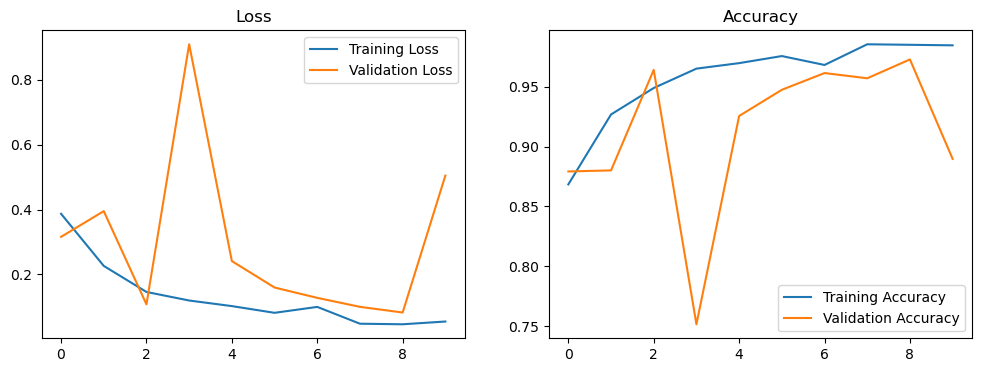

In [21]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [22]:
print(path_test)

image_count = len(list(path_test.glob('*/*.jpg')))
print(image_count)

Dataset\Brain-tumor\Testing
1311


In [23]:
# Evaluate on test set
test_dataset = datasets.ImageFolder(root=path_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_classes = test_dataset.classes

In [24]:
model.eval()
test_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9008


In [15]:
# Save the model as a pth file
torch.save(model.state_dict(), "model_resnet18.pth")
print("Model saved as model_resnet18.pth")

Model saved as model_resnet18.pth


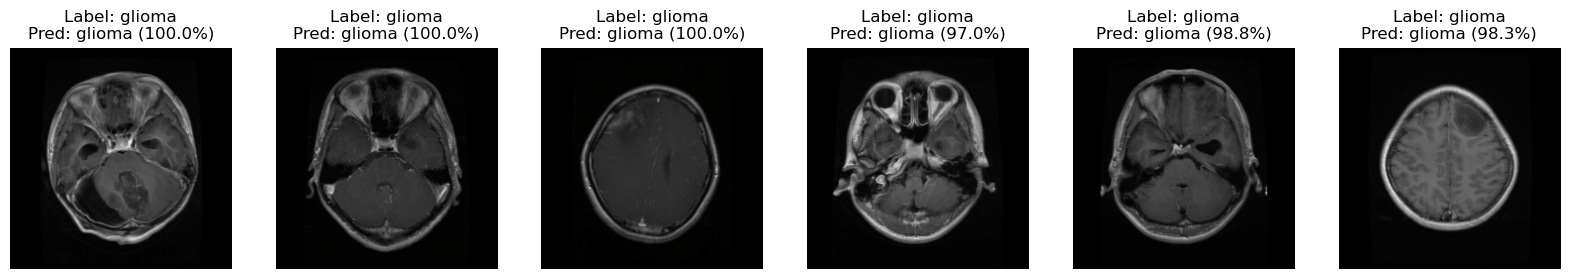

In [16]:
# Visualizing predictions with probabilities
def visualize_predictions(model, data_loader, classes, num_images=6):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    return
                ax = axes[images_shown]
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
                probability = probabilities[i, preds[i]].item() * 100
                ax.imshow(img)
                ax.set_title(f"Label: {classes[labels[i]]}\nPred: {classes[preds[i]]} ({probability:.1f}%)")
                ax.axis('off')
                images_shown += 1

# Visualize some predictions 
visualize_predictions(model, test_loader, train_dataset.dataset.classes)

In [17]:
# Print class names
print("Train Classes:", train_classes)
print("Val Classes:", val_classes)
print("Test Classes:", test_classes)

Train Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Val Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [18]:
!pip install ipywidgets

In [19]:
# Function to predict a single image from a path
def predict_single_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        pred_class = probabilities.argmax(dim=1).item()
        confidence = probabilities[0, pred_class].item() * 100
    print(f"Predicted: {train_classes[pred_class]} with confidence {confidence:.2f}%")

# Example usage
image_path = "D:/Fauzan/Misc/Workspace/ECD/Dataset/Brain-tumor/Training/pituitary/Tr-pi_0023.jpg"  # Replace with your image path
predict_single_image(image_path)

FileUpload(value=(), accept='image/*', description='Upload')

AttributeError: 'tuple' object has no attribute 'items'